## ARIMA Anomaly Detection Dataset COVID-19 DKI Jakarta

Oleh: Arsyi Adlani - Tim Ardito CompFest13 Data Science 2021

## Latar Belakang

Terhitung pada tanggal 18 Juli 2021, pandemi Covid-19 (Corona Virus Disease 2019) telah
melanda Indonesia selama 16 bulan sejak pemerintah Indonesia mengumumkan ditemukannya
dua kasus pertama Covid-19 pada 2 Maret 2020. Sejak saat itu, berbagai usaha telah dilakukan
baik oleh pemerintah pusat maupun pemerintah daerah untuk menekan laju penyebaran dan
fatalitas Covid-19. Pemprov DKI Jakarta telah berulang kali menerapkan Pembatasan Sosial
Berskala Besar (PSBB), mulai dari tiga fase PSBB ketat, PSBB transisi, Pemberlakuan
Pembatasan Kegiatan Masyarakat (PPKM) Mikro, hingga akhirnya pemerintah secara terpusat
menarik rem darurat dengan kebijakan PPKM Darurat Jawa-Bali pada 3 Juli 2021.

Namun demikian, hingga 19 Juli 2021, DKI Jakarta menjadi penyumbang kasus terkonfirmasi tertinggi sebanyak 727,010 kasus atau 26.1% dari 2,877,476 kasus di Indonesia dengan kasus positif aktif tertinggi di Indonesia yaitu
sebanyak 112,957 kasus. Dengan menggunakan dataset yang diperoleh dari situs resmi pemantauan Covid-19 Pemprov DKI Jakarta corona.jakarta.go.id, kami melakukan analisis pendeteksian outliers (anomali) sederhana pada penyebaran kasus Covid-19 di DKI Jakarta. Kami menggunakan variabel ‘Positif Harian’ pada bagian dataset ‘Data Jakarta’ untuk melakukan pendeteksian outliers.

## Exploratory Data Analysis

In [1]:
import dtale
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox 
from scipy.stats import yeojohnson
from scipy.stats import skew
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

### A. Eksplorasi Awal Data

In [2]:
data = pd.read_csv("Data Jakarta.csv", usecols=['Tanggal', 'Positif Harian'])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Tanggal         498 non-null    object
 1   Positif Harian  498 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [4]:
data['Tanggal'] = pd.to_datetime(data['Tanggal'])
data.set_index('Tanggal', inplace=True)

In [5]:
data.head()

,Positif Harian
Tanggal,
2020-03-01,0
2020-03-02,0
2020-03-03,3
2020-03-04,0
2020-03-05,4


In [6]:
data.describe()

,Positif Harian
count,498.000000
mean,1330.204819
std,1935.925803
min,0.000000
25%,213.500000
50%,875.500000
75%,1434.750000
max,13133.000000


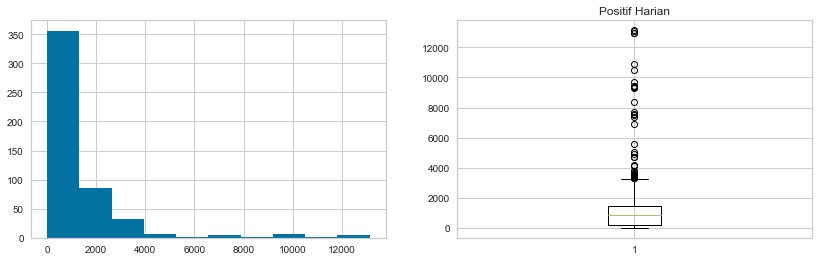

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))
plt.title('Positif Harian')
ax1.hist(data['Positif Harian'], density=False)
ax2.boxplot(data['Positif Harian'])
plt.show()

In [8]:
data['Positif Harian'].skew()

3.6166639843620474

Dari visualisasi tersebut, diperoleh informasi bahwa variabel ‘Positif Harian’ memiliki distribusi right-skewed dengan koefisien skewness sebesar 3.616. Jika kita memandang data ‘Positif Harian’ tanpa sifat sekuensialnya terhadap waktu, dapat terlihat bahwa banyak titik data yang berada di luar jarak 1.5 IQR (Interquartile Range) dari nilai median. Hal ini yang menyebabkan distribusi data menjadi skewed.

### B. Eksplorasi Lanjutan

Pada bagian sebelumnya, seluruh analisis yang dilakukan belum mempertimbangkan karakteristik
sekuensial time series yang sebenarnya dimiliki oleh variabel Positif Harian. Selanjutnya akan dilakukan analisis sifat sekuensial variabel Positif Harian terhadap Tanggal yang menjadi indeks data.

In [9]:
data['Hari Ke-'] = np.arange(1, len(data)+1, 1)

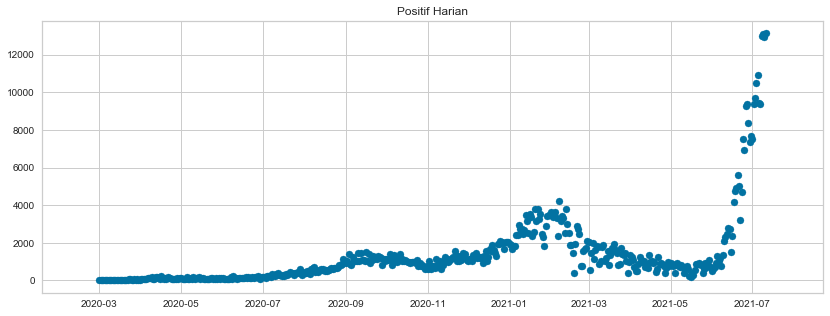

In [10]:
fig, (ax1) = plt.subplots(1,figsize=(14,5))
plt.title('Positif Harian')
ax1.scatter(x=data.index, y=data['Positif Harian'])

In [11]:
data[['Hari Ke-', 'Positif Harian']].cov()

,Hari Ke-,Positif Harian
Hari Ke-,20708.500000,1.564882e+05
Positif Harian,156488.173038,3.747809e+06


In [12]:
data[['Hari Ke-', 'Positif Harian']].corr(method='pearson')

,Hari Ke-,Positif Harian
Hari Ke-,1.000000,0.561718
Positif Harian,0.561718,1.000000


In [13]:
data[['Hari Ke-', 'Positif Harian']].corr(method='spearman')

,Hari Ke-,Positif Harian
Hari Ke-,1.000000,0.753623
Positif Harian,0.753623,1.000000


Visualisasi tersebut membuktikan analisis awal sebelumnya bahwa mayoritas data positif
harian berada pada level yang relatif rendah, namun terjadi kenaikan hampir secara
eksponensial pada kuartal akhir data. Analisis kovarians yang memberikan nilai positif
(1.564e+05) menunjukkan tren kenaikan data. Terlihat kenaikan mulai terjadi dari pertengahan
bulan Juni 2021 hingga akhir data (11 Juli 2021). Hasil tersebut juga didukung oleh analisis korelasi yang memberikan 
nilai positif: 0.562 (Pearson' correlation) dan 0.754 (Spearman's correlation). Dari visualisasi, terlihat adanya hubungan yang nonlinear antara variabel Positif Harian dengan Tanggal. Hal inilah yang turut menyebabkan diperolehnya nilai koefisien korelasi Spearman yang lebih tinggi.

## Ouliers Analysis

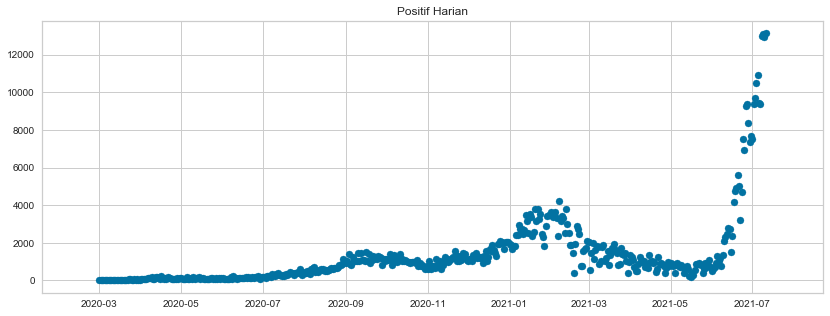

In [14]:
fig, (ax1) = plt.subplots(1,figsize=(14,5))
plt.title('Positif Harian')
ax1.scatter(x=data.index, y=data['Positif Harian'])

Dari analisis lanjutan, terlihat bahwa data variabel ‘Positif Harian’ merupakan time series dan
memiliki sifat sekuensial dengan tren tertentu. Hal ini sangat krusial untuk diperhatikan karena
pendeteksian outliers pada time series, atau disebut juga dengan anomaly detection,
membutuhkan penanganan tersendiri yang membuat analisis statistik untuk outliers seperti
analisis z-score maupun analisis Interquartile Range (IQR) tidak dapat langsung digunakan.

## A. Naive Methods for Outliers

Pada bagian ini, dilakukan analisis outliers metode z-score dan interquartile range (IQR) tanpa mempertimbangkan sifat sekuensial time series yang sebenarnya dimiliki oleh data Positif Harian.

### Z-Score Method

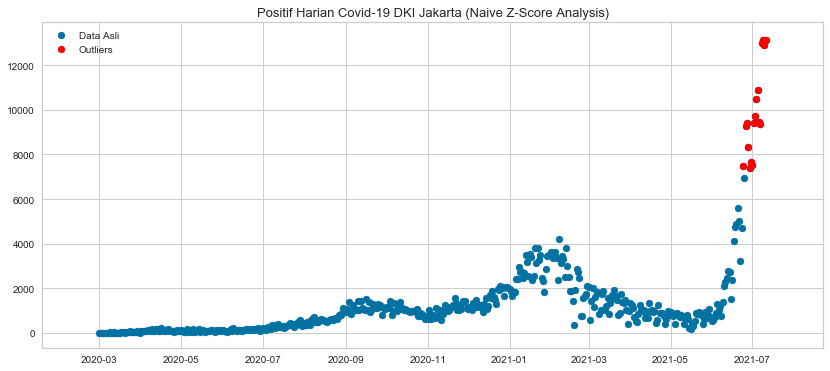

In [15]:
up_thres = data['Positif Harian'].mean() + (3*data['Positif Harian'].std())
down_thres = data['Positif Harian'].mean() - (3*data['Positif Harian'].std())
out_index = data['Hari Ke-'][(data['Positif Harian'] > up_thres) | (data['Positif Harian'] < down_thres)] - 1

fig, ax = plt.subplots(1,1,figsize=(14,6))
plt.title('Positif Harian Covid-19 DKI Jakarta (Naive Z-Score Analysis)', fontsize=13)
ax.scatter(data.index, data['Positif Harian'], label='Data Asli')
ax.scatter(data.index[out_index], data['Positif Harian'][out_index], c='Red', label='Outliers')
plt.legend()

In [16]:
print(f'{out_index.count()} outliers')

17 outliers


In [17]:
data.iloc[out_index]

,Positif Harian,Hari Ke-
Tanggal,,
2021-06-24,7505,481
2021-06-26,9271,483
2021-06-27,9394,484
2021-06-28,8348,485
2021-06-29,7379,486
2021-06-30,7680,487
2021-07-01,7541,488
2021-07-02,9399,489
2021-07-03,9702,490


### Inter-Quartile Range (IQR) Method

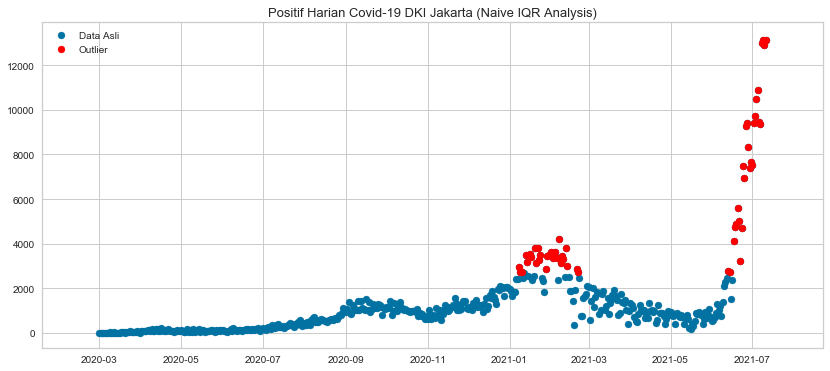

In [18]:
IQR = data['Positif Harian'].quantile(0.75) - data['Positif Harian'].quantile(0.25)
up_thres = data['Positif Harian'].median() + (1.5 * IQR)
down_thres = data['Positif Harian'].median() - (1.5 * IQR)
out_index = data['Hari Ke-'][(data['Positif Harian'] > up_thres) | (data['Positif Harian'] < down_thres)] - 1

fig, ax = plt.subplots(1,1,figsize=(14,6))
plt.title('Positif Harian Covid-19 DKI Jakarta (Naive IQR Analysis)', fontsize=13)
ax.scatter(data.index, data['Positif Harian'], label='Data Asli')
ax.scatter(data.index[out_index], data['Positif Harian'][out_index], c='Red', label='Outlier')
plt.legend()

In [19]:
print(f'{out_index.count()} outliers')

56 outliers


In [20]:
data.iloc[out_index]

,Positif Harian,Hari Ke-
Tanggal,,
2021-01-08,2959,314
2021-01-09,2753,315
2021-01-10,2711,316
2021-01-13,3476,319
2021-01-14,3165,320
2021-01-16,3536,322
2021-01-17,3395,323
2021-01-20,3786,326
2021-01-21,3151,327


### Analisis Tambahan (Data Transformation)

Pada eksplorasi data sebelumnya, diperoleh informasi bahwa data Positif Harian memiliki distribusi right-skewed. Kami mencoba melakukan transformasi data terlebih dahulu untuk membuat data menjadi lebih berdistribusi normal. Data yang telah ditransformasi kemudian akan dilakukan analisis Z-Score dengan threshold sebesar 3 standar deviasi dari mean.

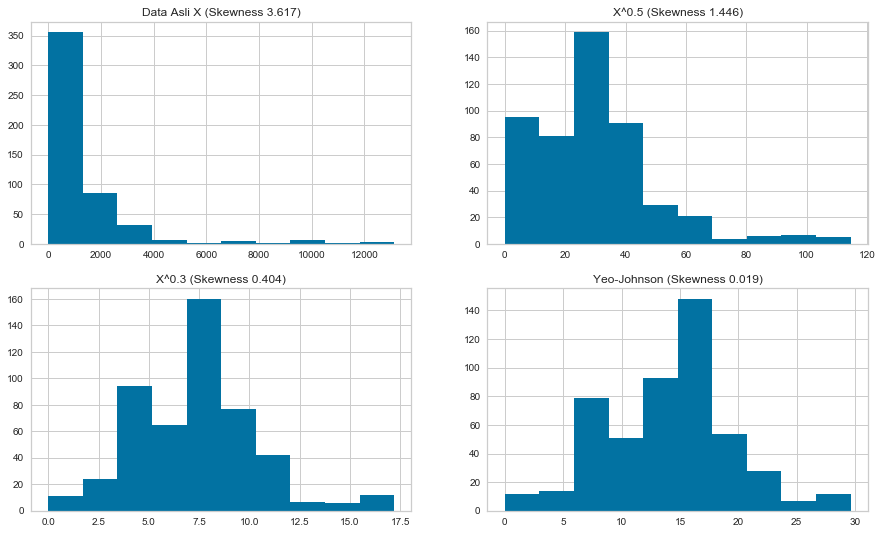

In [21]:
fig, ax = plt.subplots(2,2,figsize=(15,9))

skew_a = (data['Positif Harian']).skew()
ax[0,0].hist(data['Positif Harian'], density=False)
ax[0,0].set_title(f'Data Asli X (Skewness {skew_a:.3f})')

skew_b = (data['Positif Harian']**0.5).skew()
ax[0,1].hist(data['Positif Harian']**0.5, density=False)
ax[0,1].set_title(f'X^0.5 (Skewness {skew_b:.3f})')

skew_c = (data['Positif Harian']**0.3).skew()
ax[1,0].hist(data['Positif Harian']**0.3, density=False)
ax[1,0].set_title(f'X^0.3 (Skewness {skew_c:.3f})')

trans_data, lambda_data = yeojohnson(data['Positif Harian'])
skew_yeo = skew(trans_data)
ax[1,1].hist(trans_data, density=False)
ax[1,1].set_title(f'Yeo-Johnson (Skewness {skew_yeo:.3f})')

plt.show()

Terlihat bahwa transformasi Yeo-Johnson memberikan pendekatan terbaik terhadap distribusi normal.

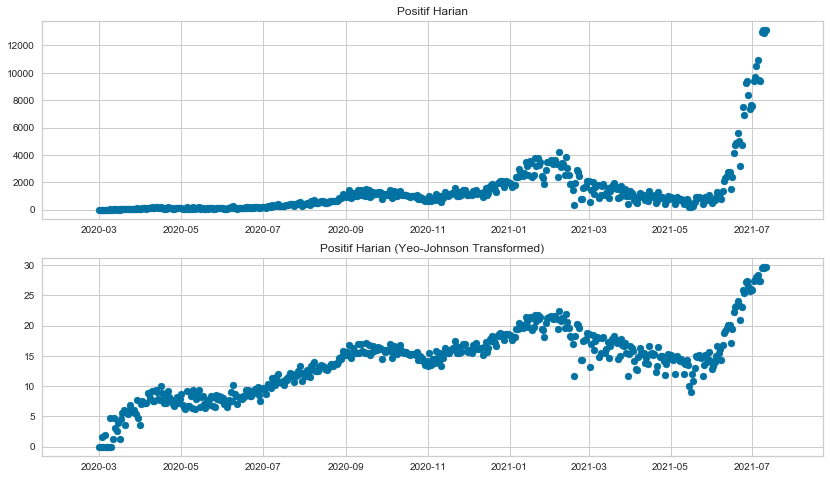

In [22]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,8))
ax1.set_title('Positif Harian')
ax1.scatter(x=data.index, y=data['Positif Harian'])
ax2.set_title('Positif Harian (Yeo-Johnson Transformed)')
ax2.scatter(x=data.index, y=trans_data)

### Z-Score Analysis (3-sigma) with Transformed Data

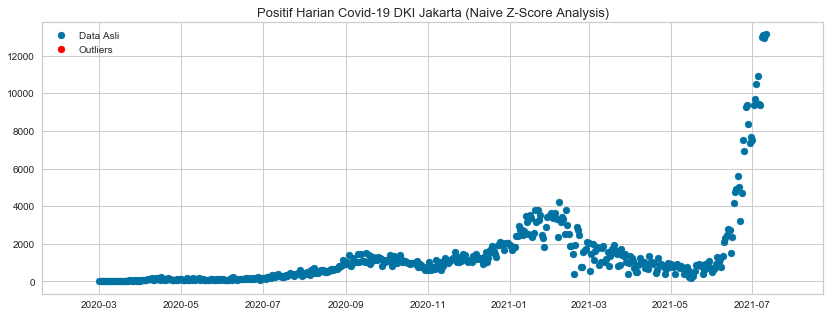

In [23]:
up_thres = trans_data.mean() + (3*(trans_data.std()))
down_thres = trans_data.mean() - (3*(trans_data.std()))
out_index = data['Hari Ke-'][(trans_data > up_thres) | (trans_data < down_thres)] - 1

fig, ax = plt.subplots(1,1,figsize=(14,5))
plt.title('Positif Harian Covid-19 DKI Jakarta (Naive Z-Score Analysis)', fontsize=13)
ax.scatter(data.index, data['Positif Harian'], label='Data Asli')
ax.scatter(data.index[out_index], data['Positif Harian'][out_index], c='Red', label='Outliers')
plt.legend()

In [24]:
print(f'{out_index.count()} outliers')

0 outliers


### Inter-Quartile Range (IQR) Method with Transformed Data

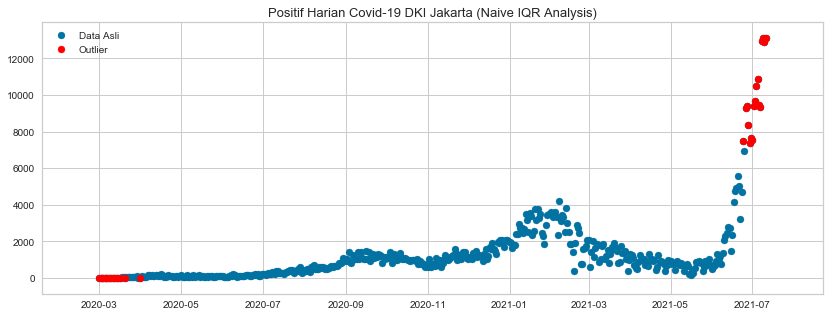

In [25]:
IQR = np.quantile(trans_data, q=0.75) - np.quantile(trans_data, q=0.25)
up_thres = np.quantile(trans_data, q=0.5) + (1.5 * IQR)
down_thres = np.quantile(trans_data, q=0.5) - (1.5 * IQR)
out_index = data['Hari Ke-'][(trans_data > up_thres) | (trans_data < down_thres)] - 1

fig, ax = plt.subplots(1,1,figsize=(14,5))
plt.title('Positif Harian Covid-19 DKI Jakarta (Naive IQR Analysis)', fontsize=13)
ax.scatter(data.index, data['Positif Harian'], label='Data Asli')
ax.scatter(data.index[out_index], data['Positif Harian'][out_index], c='Red', label='Outlier')
plt.legend()

In [26]:
print(f'{out_index.count()} outliers')

33 outliers


In [27]:
data.iloc[out_index]

,Positif Harian,Hari Ke-
Tanggal,,
2020-03-01,0,1
2020-03-02,0,2
2020-03-03,3,3
2020-03-04,0,4
2020-03-05,4,5
2020-03-06,0,6
2020-03-07,0,7
2020-03-08,0,8
2020-03-10,0,10


Percobaan analisis ini memberikan hasil yang cukup menarik. Pada analisis IQR misalnya, transformasi Yeo-Johnson membuat outliers data menjadi 33 titik data dari yang sebelumnya sebanyak 56 titik data. Bahkan pada analisis Z-score, diperoleh 0 outliers dari yang sebelumnya sebanyak 17 outliers. Artinya, teknik transformasi data tidak hanya akan mengurangi skewness (dengan mengubah distribusi data menjadi lebih berdistribusi normal), namun juga secara tidak langsung akan turut menangani outliers pada data.

Namun, tentu saja data hasil transformasi tidak memberikan makna real sehingga tidak bisa digunakan dalam proses analisis data. Teknik ini mungkin akan sangat berguna pada data preprocessing sebelum dimasukkan ke dalam model machine learning yang umumnya menjadikan data yang berdistribusi normal sebagai 'primadona'.

## B. Outliers Detection with ARIMA

Dari analisis pada bagian sebelumnya, dapat terlihat ada masalah yang muncul pada pendeteksian outliers yang
dilakukan. Pada analisis z-score dengan threshold z sebesar 3 sigma (standar deviasi) dari mean
tersebut, data positif harian mulai dari tanggal 24 Juni 2021 (7505 kasus positif) dan seterusnya
hingga 11 Juli 2021 diklasifikasikan sebagai outliers seluruhnya. Padahal, data tersebut
merupakan bagian dari tren data yang memang mengalami kenaikan secara eksponensial sejak
pertengahan bulan Juni 2021 hingga Juli 2021. False positives ini disebabkan oleh tidak
diikutsertakannya sifat sekuensial dari data time series yang memungkinkannya memiliki tren
dan siklus (seasonality) dalam melakukan pendeteksian outliers.

Untuk mengatasi hal tersebut, kami memutuskan untuk melakukan analisis ARIMA
(Autoregressive Integrated Moving Average). Model ARIMA akan digunakan untuk melakukan fitting
terhadap data asli dan menghasilkan data baru yang mendekati data asli namun lebih smooth.
Hasil prediksi ARIMA ini yang akan kami jadikan ground truth sebagai data ‘normal’. Model
ARIMA dipilih karena data positif harian terlihat tidak memiliki seasonality. 

### Stationary Testing

ARIMA mensyaratkan data time series untuk memiliki sifat stasioner, yaitu karakteristik data hanya bergantung pada selisih (difference) dari suatu selang waktu, bukan tergantung pada kapan selang waktu tersebut terjadi. Untuk itu, data dapat dikatakan stasioner jika memiliki karakteristik:
1. Mean dan varians yang stabil 
2. Tidak memiliki trend
3. Tidak memiliki seasonality

In [29]:
from statsmodels.tsa.stattools import adfuller

def adfullertest(data):
    result = adfuller(data)
    print(f'ADF Statistics: {result[0]}')
    print(f'p-Value: {result[1]}')
    if result[1] < 0.05:
        print('Stationary')
    else:
        print('Non-Stationary')

Augmented Dickey-Fuller (ADF test) merupakan pengujian statistik untuk mengukur stationarity data. Pengujian ini memiliki hipotesis nol (H0) bahwa data tidak stasioner. Umumnya jika p-value < 0.05, maka dianggap telah cukup bukti untuk menolak H0 dan menerima H1 bahwa data telah memiliki sifat stasioner.

In [32]:
adfullertest(data['Positif Harian'])

ADF Statistics: 0.13230321881231993
p-Value: 0.9681986258829549
Non-Stationary


Hasil ADF Test menunjukkan p-value > 0.05 yaitu sebesar 0.96. Dari nilai ini dapat ditarik kesimpulan bahwa data masih sangat jauh dari sifat stasioner untuk dapat dijadikan sebagai input ARIMA. Untuk itu, akan digunakan teknik differencing untuk menghilangkan trend dari data dan sekaligus membuat data menjadi lebih stasioner.

### Differencing Technique

In [49]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA

#### Data Asli Positif Harian

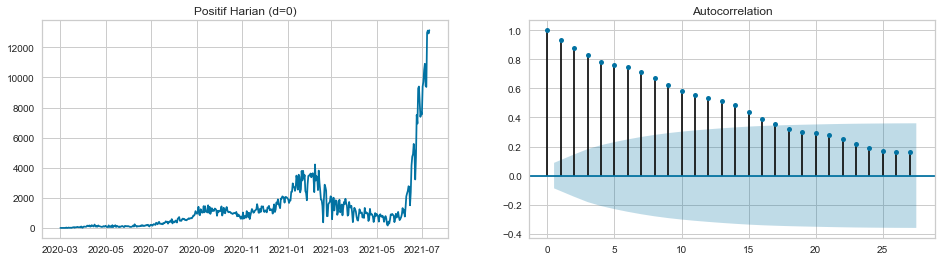

In [48]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(data['Positif Harian'])
ax1.set_title('Positif Harian (d=0)')
plot_acf(data['Positif Harian'], ax=ax2);

Dari visualisasi, mudah terlihat bahwa data asli masih jauh dari sifat stasioner. Data memiliki trend yang terlihat meningkat eksponensial pada kuartal akhir data dan memiliki mean serta varians yang fluktuatif sepanjang indeks Tanggal.

#### First Order Differencing (d=1)

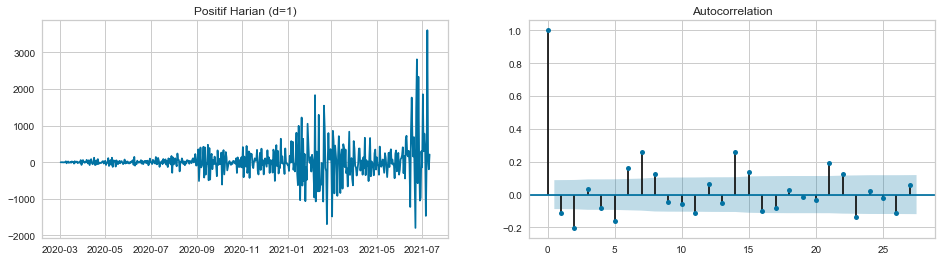

In [47]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(data['Positif Harian'].diff().dropna())
ax1.set_title('Positif Harian (d=1)')
plot_acf(data['Positif Harian'].diff().dropna(), ax=ax2);

Penggunaan teknik differencing sebanyak satu kali terlihat telah berhasil menekan trend dari data dan membuat data menjadi lebih stabil. Selanjutnya dapat diperiksa penggunaan differencing sebanyak dua kali untuk melihat apakah ada perbaikan lebih lanjut yang signifikan.

#### Second Order Differencing (d=2)

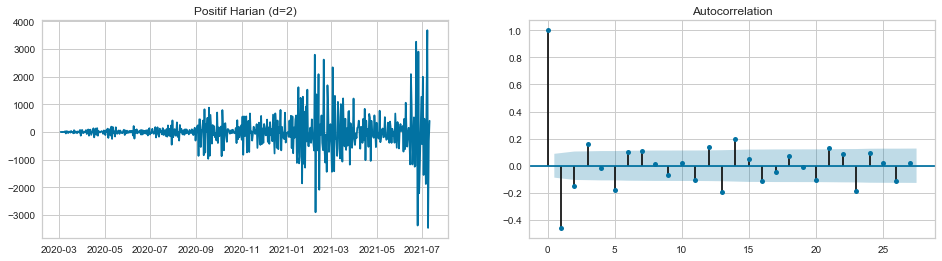

In [46]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(data['Positif Harian'].diff().diff().dropna())
ax1.set_title('Positif Harian (d=2)')
plot_acf(data['Positif Harian'].diff().diff().dropna(), ax=ax2);

Terlihat bahwa differencing sebanyak dua kali tidak terlalu membawa perubahan berarti pada data yang dilakukan differencing sebanyak satu kali. Dari informasi ini, akan digunakan parameter differencing ARIMA d=1. Hasil tersebut juga didukung oleh hasil pencarian otomatis jumlah diferensiasi (ndiffs) menggunakan library pmdarima berikut:

In [40]:
from pmdarima.arima.utils import ndiffs

ndiff = ndiffs(data['Positif Harian'], test='adf')
print(f'Differencing coefficient d = {ndiff}')

Differencing coefficient d = 1


### Autoregression (AR) Parameter

Parameter Autoregression (p) pada ARIMA merupakan jumlah lags yang digunakan ARIMA untuk melakukan prediksi. Dengan kata lain, parameter ini menunjukkan seberapa jauh ARIMA akan meihat past values untuk melakukan prediksi terhadap data baru. Untuk menentukannya dapat digunakan analisis Partial Autocorrelation Function (PACF).

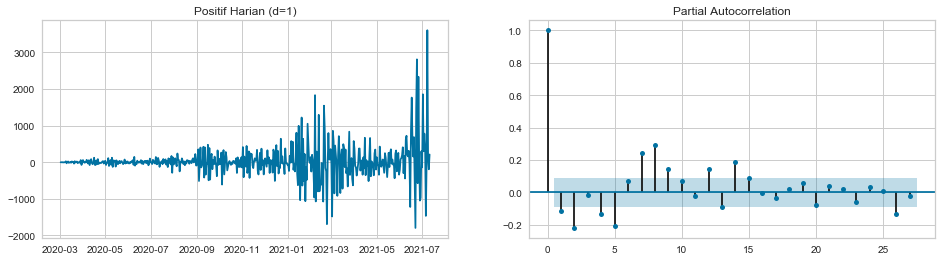

In [45]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(data['Positif Harian'].diff().dropna())
ax1.set_title('Positif Harian (d=1)')
plot_pacf(data['Positif Harian'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 7.

### Moving Average (MA) Parameter

Parameter Moving Average (q) pada ARIMA menunjukkan seberapa jauh error lags yang dipertimbangkan untuk melakukan prediksi. Parameter ini dapat ditentukan dengan menggunakan analisis Autocorrelation Function (ACF).

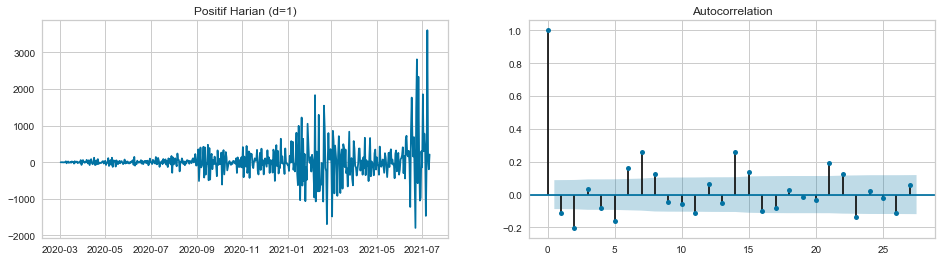

In [44]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(data['Positif Harian'].diff().dropna())
ax1.set_title('Positif Harian (d=1)')
plot_acf(data['Positif Harian'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 5.

### ARIMA Model

Dari analisis sebelumnya, akan digunakan model ARIMA untuk melakukan fitting terhadap data asli Positif Harian dengan parameter:
- ARIMA(p,d,q) = ARIMA(7,1,5)

In [ ]:
model = ARIMA(data['Positif Harian'], order=(7,1,5))
result = model.fit(disp=0)

In [51]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.Positif Harian   No. Observations:                  497
Model:                 ARIMA(7, 1, 5)   Log Likelihood               -3634.566
Method:                       css-mle   S.D. of innovations            361.314
Date:                Wed, 04 Aug 2021   AIC                           7297.132
Time:                        20:30:49   BIC                           7356.052
Sample:                    03-02-2020   HQIC                          7320.258
                         - 07-11-2021                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     53.4614     59.362      0.901      0.368     -62.885     169.808
ar.L1.D.Positif Harian     1.5137      0.155      9.759      0.000       1.210       1.818
ar.L

### Model Fitting

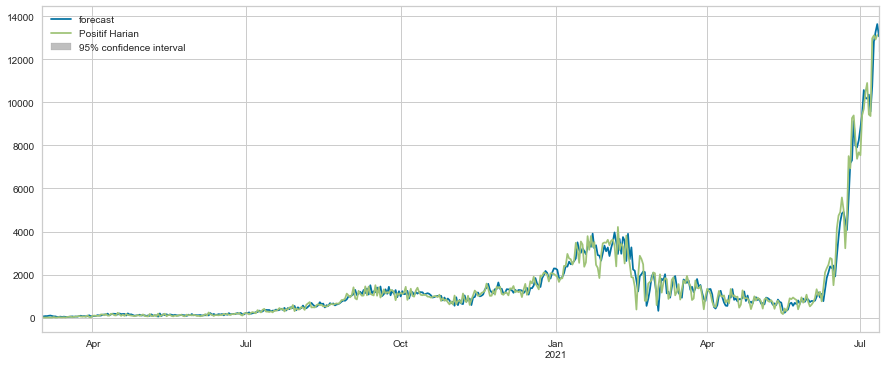

In [56]:
fig,ax = plt.subplots(1,1,figsize=(15,6))
result.plot_predict(start=1, end=498, dynamic=False, ax=ax);

Dari visualisasi di atas, diperoleh hasil fitting dan prediksi model ARIMA terhadap data asli Positif Harian. Hasil forecast ARIMA (biru) akan dijadikan sebagai ground truth data 'normal' dalam pencarian outliers. Error selisih prediksi ARIMA dengan data asli dapat dilihat pada visualisasi berikut:

Text(0.5, 1.0, 'Residual Error')

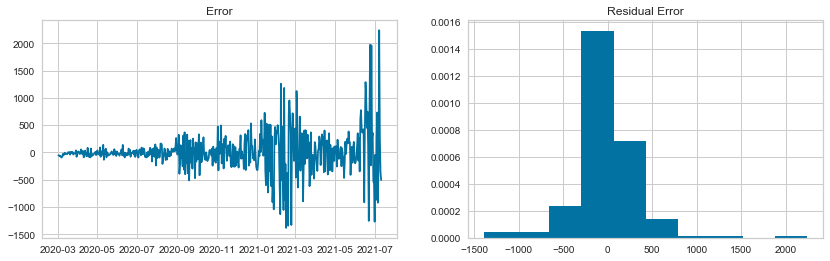

In [61]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,4))
ax1.plot(result.resid)
ax1.set_title('Error')
ax2.hist(result.resid, density=True)
ax2.set_title('Residual Error')

In [70]:
result.resid.skew()

0.7595146425027856

Diperoleh error dengan distribusi yang mendekati distribusi normal dengan koefisien skewness sebesar 0.759. Dengan demikian, dapat digunakan analisis Z-Score pada data error residual dengan threshold 3 standar deviasi dari mean untuk menentukan titik-titik data yang merupakan outliers atau anomali.

### Time Series Outliers Detection

In [71]:
data['PH_forecast'] = result.predict(start=1, end=498, typ='levels')
data['Error'] = data['Positif Harian'] - data['PH_forecast']

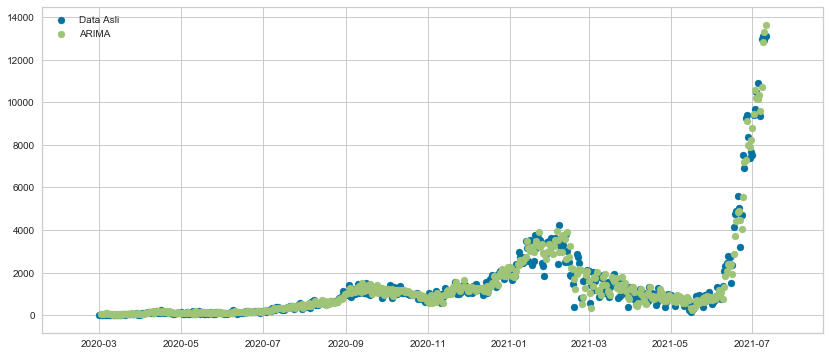

In [83]:
fig, ax = plt.subplots(1,1,figsize=(14,6))
ax.scatter(data.index, data['Positif Harian'], label='Data Asli')
ax.scatter(data.index, data['PH_forecast'], label='ARIMA')
plt.legend()

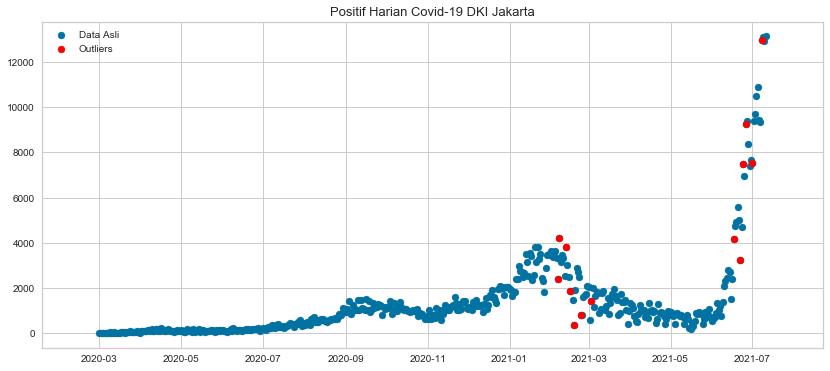

In [80]:
up_stat_thres = data['Error'].mean() + (3 * data['Error'].std())
down_stat_thres = data['Error'].mean() - (3 * data['Error'].std())
out_index = data['Hari Ke-'][(data['Error'] > up_stat_thres) | (data['Error'] < down_stat_thres)] - 1

fig, ax = plt.subplots(1,1,figsize=(14,6))
plt.title('Positif Harian Covid-19 DKI Jakarta', fontsize=13)
ax.scatter(data.index, data['Positif Harian'], label='Data Asli')
ax.scatter(data.index[out_index], data['Positif Harian'][out_index], c='Red', label='Outliers')
plt.legend()

In [79]:
print(f'{out_index.count()} outliers')

13 outliers


In [77]:
data[['Positif Harian', 'Hari Ke-']].iloc[out_index]

,Positif Harian,Hari Ke-
Tanggal,,
2021-02-06,2379,343
2021-02-07,4213,344
2021-02-12,3810,349
2021-02-15,1879,352
2021-02-18,373,355
2021-02-23,782,360
2021-03-03,1437,368
2021-06-17,4144,474
2021-06-22,3221,479


Dengan melakukan analisis Z-Score dengan static threshold sebesar 3 standar deviasi dari mean pada data error residual, diperoleh 13 outliers pada data. Terlihat bahwa diperoleh hasil yang cukup baik dalam pendeteksian outliers atau anomaly
sesuai dengan tren lokal dari data. Data yang memiliki penyimpangan signifikan dari tren lokal,
meskipun besar nilainya jauh dari nilai ekstrem global tetap dapat berhasil terdeteksi sebagai
data outliers.

### Analisis Tambahan: Dynamic Threshold

Menariknya, dengan adanya informasi error residual setiap titik data terhadap prediksi ARIMA, maka threshold outliers yang digunakan juga dapat bersifat dinamis. Nilai mean yang digunakan untuk mengukur batas atas dan bawah outliers tidak perlu harus mean global dataset, namun dapat berupa mean lokal dengan time window tertentu, seperti mean 1 bulan terakhir, 2 bulan terakhir, dsb. Teknik ini dapat membuat pendeteksian outliers menjadi semakin sensitif dalam menyesuaikan diri dengan trend lokal data. 

Berikut merupakan dynamic thresholding data Positif Harian dengan time window 2 bulan (60 hari) dan threshold penyimpangan sebesar 2.7 standar deviasi dari mean masing-masing time window.

In [85]:
data_copy = data.copy()
std_coef = 2.7  # Besar standar deviasi penyimpangan dari mean window
window = 60  # 60 Hari (2 bulan)

data_copy['mean'] = pd.Series(data_copy['Error'].rolling(window=window).mean())
data_copy['std'] = pd.Series(data_copy['Error'].rolling(window=window).std())
data_copy['up_thres'] = pd.Series(data_copy['Error'].rolling(window=window).mean()) \
                    + (std_coef * pd.Series(data_copy['Error'].rolling(window=window).std()))

data_copy['down_thres'] = pd.Series(data_copy['Error'].rolling(window=window).mean()) \
                    - (std_coef * pd.Series(data_copy['Error'].rolling(window=window).std()))

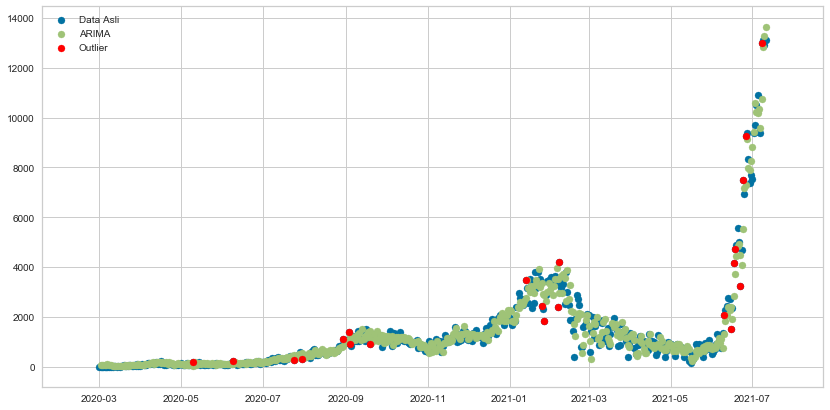

In [87]:
out_index = data_copy['Hari Ke-'][(data_copy['Error'] > data_copy['up_thres']) | (data_copy['Error'] < data_copy['down_thres'])] - 1
fig, ax = plt.subplots(1, 1, figsize=(14,7))

ax.scatter(data_copy.index, data_copy['Positif Harian'], label='Data Asli')
ax.scatter(data_copy.index, data_copy['PH_forecast'], label='ARIMA')
ax.scatter(data_copy.index[out_index], data_copy['Positif Harian'][out_index], c='Red', label='Outlier')
plt.legend()

In [88]:
print(f'{out_index.count()} outliers')

21 outliers


In [89]:
data_copy[['Positif Harian', 'Hari Ke-']].iloc[out_index]

,Positif Harian,Hari Ke-
Tanggal,,
2020-05-10,182,71
2020-06-09,239,101
2020-07-24,285,146
2020-07-30,299,152
2020-08-30,1114,183
2020-09-03,1406,187
2020-09-04,895,188
2020-09-19,932,203
2021-01-13,3476,319


Penggunaan time window pada dynamic thresholding terlihat memberikan hasil yang lebih selektif dan ketat terhadap penyimpangan setiap titik data. Titik data yang memiliki penyimpangan relatif terhadap trend 2 bulan terakhir dikategorikan sebagai data outliers atau anomali 

## Referensi

JAKARTA HEALTHY, SAFE. Jakarta's COVID-19 Response Team. (n.d.).
https://corona.jakarta.go.id/en.